In [277]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [333]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
import incense
from incense import ExperimentLoader
import matplotlib.pyplot as plt
from src import settings

loader = ExperimentLoader(
    mongo_uri=None,    
    db_name='lions'
)

In [334]:
def find_similar(exp):
    """function to find based on hash.
    """
    hash_ = exp.to_dict()['config'][settings.EXP_HASH]
    return loader.find_by_config_key(settings.EXP_HASH, hash_)

def hash_based_bundle(exps):
    bundles = {}
    for exp in exps:
        hash_ = exp.to_dict()['config'][settings.MODEL_HASH]
        if hash_ in bundles:
            bundles[hash_].append(exp)
        else:
            bundles[hash_] = [exp]
    return bundles

def get_bo_plots(exp):
    return {k: v for k,v in exp.artifacts.items() if k.startswith('bo-plot')}

# Show aggregate


In [335]:
# From one to all of same hash.

query = {"$and": [
            {"config.model.name": "GPModel"},
        ]}
exp = loader.find(query)[0]
exps = find_similar(exp)

In [336]:
# display name
# list of exp

def get_exp_key_col(exp):
    config = exp.to_dict()['config']
    return {
        'model': config['model']['name'],
        'model2': config.get('model2', {}).get('name', None),
        'acq': config.get('acquisition_function', {}).get('name'),
        'bo': bool(config.get('bo', None)),
        'f': config['obj_func']['name'],
    }

exps = loader.find({})
bundles = hash_based_bundle(exps)
bundles = {k: dict(count=len(v), exps=v, **get_exp_key_col(v[0])) for k,v in bundles.items()}

df = pd.DataFrame.from_dict(bundles, orient='index')
df

,count,exps,model,model2,acq,bo,f
171e81dbd59c63c527f2dbb2ddc599c842c66bed,6,"[Experiment(id=9, name=lions), Experiment(id=1...",DKLGPModel,None,None,False,IncreasingOscillation
25521fe347bf8c87c464be0b7974976f2ad1cba2,3,"[Experiment(id=13, name=lions), Experiment(id=...",DKLGPModel,None,None,False,Kink2D
976a8db277b33344e26f9275efd53a40fa142745,3,"[Experiment(id=6, name=lions), Experiment(id=7...",LocalLengthScaleGPModel,None,QuadratureAcquisition,True,Kink2D
aca48c6340b42e3fa0e85d2baca887be630e701f,3,"[Experiment(id=3, name=lions), Experiment(id=4...",LocalLengthScaleGPModel,None,None,False,Kink2D
b8118b0fe3bc176ac391dff3ac850662d64f3633,1,"[Experiment(id=12, name=lions)]",DKLGPModel,None,QuadratureAcquisition,True,Kink2D
fc352f8436ac309b557106ed13de819067c274fe,4,"[Experiment(id=1, name=lions), Experiment(id=2...",GPModel,LinearInterpolateModel,AcquisitionModelMismatch,True,IncreasingOscillation


## Plot BO CI

In [337]:
exps_row = df.loc[df.bo == True].iloc[0]
exps = exps_row.exps

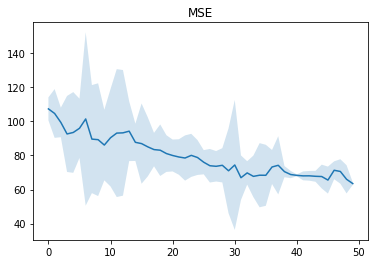

In [338]:
# Calculate mean and variance of MSE
df_concat = pd.concat([exp.metrics['mse'] for exp in exps], axis=1)
mean = df_concat.mean(axis=1)
var = df_concat.var(axis=1)
plt.title('MSE')
plt.plot(df_concat.index, mean)
plt.fill_between(df_concat.index, mean - 2 * np.sqrt(var), mean + 2 * np.sqrt(var), alpha=0.2)

In [339]:
sorted([('asd4.png', False), ('asd3.png',True)])

[('asd3.png', True), ('asd4.png', False)]

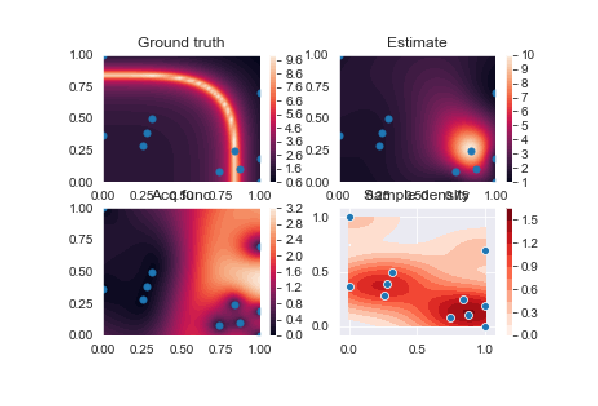

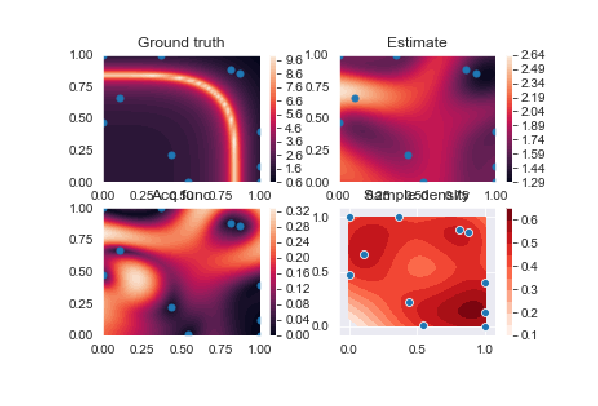

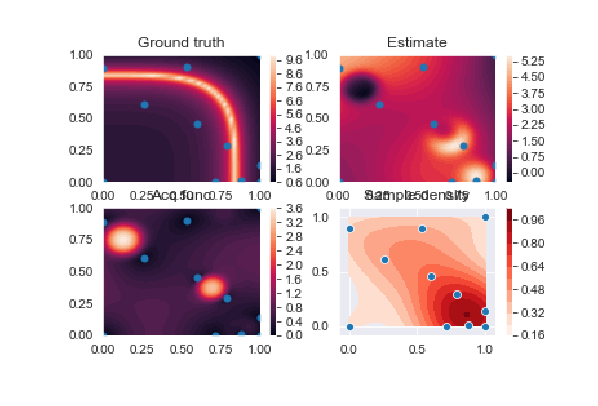

In [340]:
# Plot all last BO plot
# TODO: plot in grid
for exp in exps:
    name, last_plot = sorted(get_bo_plots(exp).items())[-1]
    last_plot.show()

## Plot GP final MSE

In [366]:
exps_rows_df = df.loc[df.bo == False]
exps_rows_df = exps_rows_df[exps_rows_df.f == 'Kink2D']
exps_rows_df = exps_rows_df.copy()
exps_rows_df

,count,exps,model,model2,acq,bo,f
25521fe347bf8c87c464be0b7974976f2ad1cba2,3,"[Experiment(id=13, name=lions), Experiment(id=...",DKLGPModel,None,None,False,Kink2D
aca48c6340b42e3fa0e85d2baca887be630e701f,3,"[Experiment(id=3, name=lions), Experiment(id=4...",LocalLengthScaleGPModel,None,None,False,Kink2D


In [367]:
# Stats on result
exps_rows_df['res'] = exps_rows_df.apply(lambda row: np.array([e.result for e in row.exps], dtype=np.float), axis=1)
exps_rows_df['res_mean'] = exps_rows_df.apply(lambda row: np.nanmean(row.res), axis=1)
exps_rows_df['res_var'] = exps_rows_df.apply(lambda row: np.nanvar(row.res), axis=1)

# Create short hand name for convinience
def get_name(row):
    name = row.model
    if row.bo: 
        name = name + " BO"
    if row.acq is not None: 
        name = name + " " + row.acq
    name = name + " " + row.f
    return name

exps_rows_df['name'] = exps_rows_df.apply(get_name, axis=1)
exps_rows_df = exps_rows_df.set_index('name')

exps_rows_df

/Users/tmpethick/anaconda3/envs/lions/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tmpethick/anaconda3/envs/lions/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  after removing the cwd from sys.path.


,count,exps,model,model2,acq,bo,f,res,res_mean,res_var
name,,,,,,,,,,
DKLGPModel Kink2D,3,"[Experiment(id=13, name=lions), Experiment(id=...",DKLGPModel,None,None,False,Kink2D,"[80.20408653660013, 79.8624446517905, 79.75854...",79.941691,0.036225
LocalLengthScaleGPModel Kink2D,3,"[Experiment(id=3, name=lions), Experiment(id=4...",LocalLengthScaleGPModel,None,None,False,Kink2D,"[nan, nan, nan]",NaN,NaN


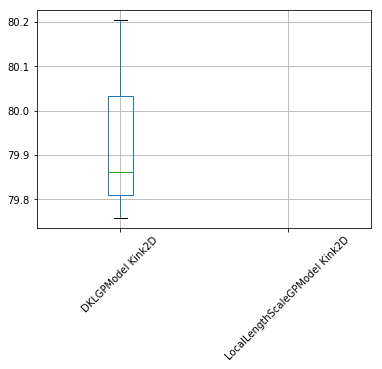

In [368]:
# Plot result (MSE) boxes!
exps_rows_df['res'].apply(lambda x: pd.Series(x)).T.boxplot(rot=45)

# Single experiment explorer

In [191]:
# Find the latest (using internal api of loader...)
exp = loader._runs.find().sort([('timestamp', -1)]).limit(1)[0]
exp = loader._make_experiment(exp)

In [192]:
#exp = loader.find_by_id(-1)

def artifact_to_numpy(artifact):
    return np.load(artifact.file)

X = artifact_to_numpy(exp.artifacts['X.npy'])
Y = artifact_to_numpy(exp.artifacts['Y.npy'])

bo_plots_dict = get_bo_plots(exp)
bo_plots = [bo_plots_dict[k] for k in sorted(bo_plots_dict.keys())]

In [193]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(i=(0, len(bo_plots)-1))
def show_bo_plot(i):
    bo_plots[i].show()

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

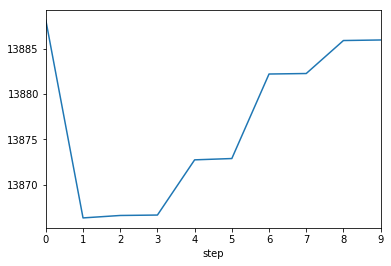

In [26]:
exp.metrics['mse'].plot()

# Dangour Zone! (Used to clean mongodb)

In [213]:
for exp in loader.find({}):
    exp.delete()#confirmed=True)